<IPython.core.display.Javascript object>


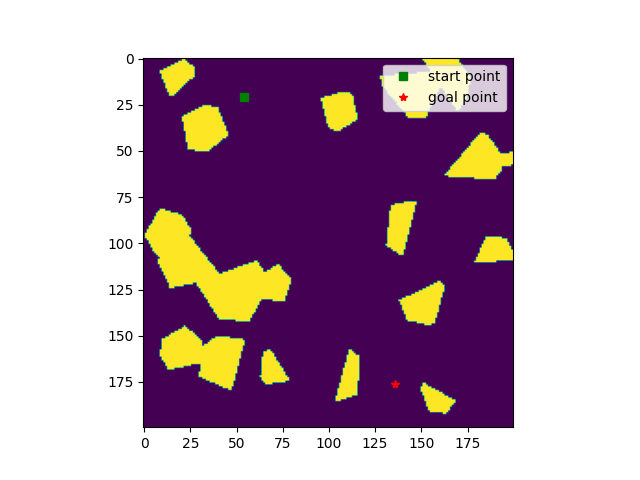

<IPython.core.display.Javascript object>


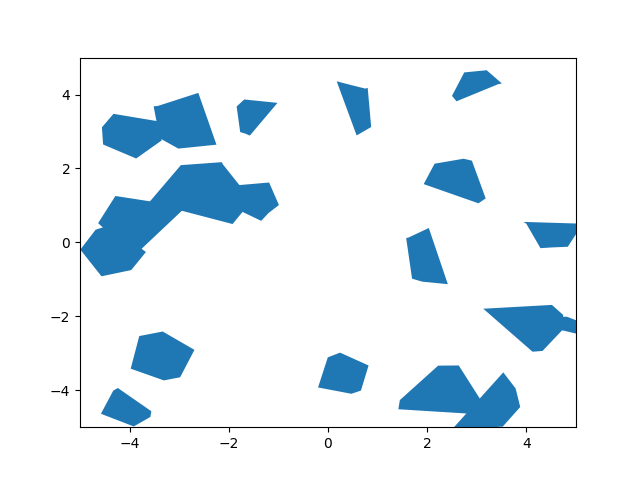

<IPython.core.display.Javascript object>


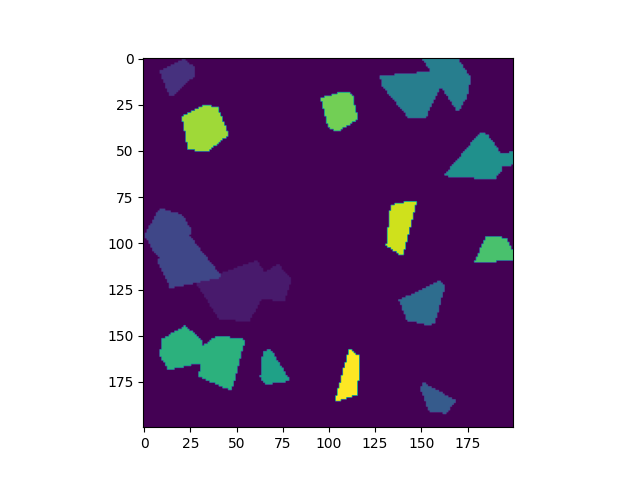

In [3]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as anim
# plt.rcParams['figure.figsize'] = [10, 5]
import heapq
import cv2
import time

def make_poly(x, y, r, n):
    """Make a convex polygon centered at (x,y) """
    ts = np.sort(np.random.uniform(0, 2*np.pi, n))
    rs = np.random.uniform(r*0.9, r*1.1, n)

    pts = np.array([rs*np.cos(ts) + x, rs*np.sin(ts) + y]).T

    poly = plt.Polygon(pts)
    return poly

def generate_random_obstacles(n, obs_type, start_pt, goal_pt):
    sigma = 2
    obstacles = []
    for i in range(n):
        x = np.random.uniform(-5,5)
        y = np.random.uniform(-5,5)
        r = np.random.uniform(0.5, 1)
        if obs_type == "circles":
            patch = plt.Circle([x, y], r)
        elif obs_type == "polygons":
            patch = make_poly(x, y, r, 6)
        else:
            raise RuntimeError("Valid obstacle types are 'circles' or 'polygons'")
        while patch.contains_point(start_pt) or patch.contains_point(goal_pt):
            x = np.random.uniform(-5,5)
            y = np.random.uniform(-5,5)
            r = np.random.uniform(0.5, 1)
            if obs_type == "circles":
                patch = plt.Circle([x, y], r)
            elif obs_type == "polygons":
                patch = make_poly(x, y, r, 6)
        obstacles.append(patch)
    return obstacles

def convert_obstacles_to_image(obstacles, img_shape, start_pt, goal_pt):
    img = -1*np.ones(img_shape)
    obs_index_img = -1*np.ones(img_shape,dtype="int")
    xmin = -5
    xmax = 5
    xs = np.linspace(xmin, xmax, img_shape[1])
    ymin = xmin*img_shape[0]/img_shape[1]
    ymax = xmax*img_shape[0]/img_shape[1]
    ys = np.linspace(ymin, ymax, img_shape[0])
    
    max_obs_index = 0
    
    all_obs_pts = []
    connected = [[]]

    for obs_index,obs in enumerate(obstacles):
        extent = obs.get_window_extent()
        imin = int((min(max(xmin, extent.x0), xmax)-xmin)
                   * img_shape[1]/(xmax-xmin))
        imax = int((min(max(xmin, extent.x1), xmax)-xmin)
                   * img_shape[1]/(xmax-xmin))
        jmin = int((min(max(ymin, extent.y0), ymax)-ymin)
                   * img_shape[0]/(ymax-ymin))
        jmax = int((min(max(ymin, extent.y1), ymax)-ymin)
                   * img_shape[0]/(ymax-ymin))
        obs_pts = []
        for i in range(imin, imax):
            for j in range(jmin, jmax):
                if obs.contains_point([xs[i], ys[j]]):
                    img[j, i] = 0
                    obs_pts.append([i,j])
                    if obs_index_img[j,i] != -1:
    
                        obs_index = obs_index_img[j,i]
        if obs_index == max_obs_index:
            max_obs_index += 1
            all_obs_pts.append([])
        
        for i,j in obs_pts:
            obs_index_img[j,i] = obs_index
        all_obs_pts[obs_index] += obs_pts
                    
    A = np.array([[img_shape[1]/(xmax-xmin), 0],
                  [0, img_shape[0]/(ymax-ymin)]])
    xscale = img_shape[1]/(xmax-xmin)
    yscale = img_shape[0]/(ymax-ymin)
    new_start = np.array(
        [(start_pt[0]-xmin)*xscale, (start_pt[1]-ymin)*yscale], dtype='int')
    img[new_start[1],new_start[0]] = -1
    new_goal = np.array(
        [(goal_pt[0]-xmin)*xscale, (goal_pt[1]-ymin)*yscale], dtype='int')
    img[new_goal[1], new_goal[0]] = -1
    return img, all_obs_pts, new_start, new_goal

def create_map(num_obstacles, obstacle_type, map_size):
    global obstacles
    start_pt = np.array([-3, 3])
    goal_pt = np.array([3, -3])
    start_pt = np.random.uniform([-5, -5], [0, 5], 2)
    goal_pt = np.random.uniform([0, -5], [5, 5], 2)
    obstacles = generate_random_obstacles(
        num_obstacles, obstacle_type, start_pt, goal_pt)
    img, all_obs_pts, img_start_pt, img_goal_pt = convert_obstacles_to_image(
        obstacles, (map_size, map_size), start_pt, goal_pt)
    return img, all_obs_pts, img_start_pt, img_goal_pt

img, all_obs_pts, img_start_pt, img_goal_pt = create_map(20, "polygons", 200)
plt.figure()
plt.imshow(img)
plt.plot(img_start_pt[0], img_start_pt[1], 'gs', label='start point')
plt.plot(img_goal_pt[0], img_goal_pt[1], 'r*', label='goal point')
plt.legend()

fig, ax = plt.subplots()
for obs in obstacles:
    ax.add_patch(obs)
ax.set_xlim(-5,5)
ax.set_ylim(-5,5)

obs_img = -1*np.ones_like(img)
for i, obs_pts in enumerate(all_obs_pts):
    for pt in obs_pts:
        obs_img[pt[1],pt[0]] = i
plt.figure()
plt.imshow(obs_img)

[[0, 0], [1, 0], [2, 0], [0, 1], [0, 2]]
[[1, 0], [0, 1]]


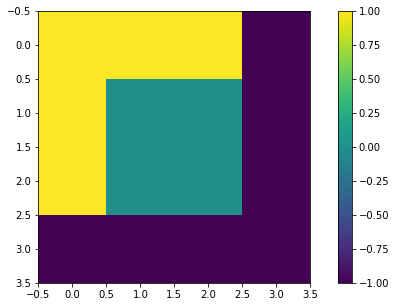

In [2]:
pairs = [[-1, -1], [0, -1], [1, -1], [-1, 0], [1, 0], [-1, 1], [0, 1], [1, 1]]

test_img = np.array(
[
    [-1,-1,-1,-1],
    [-1,0,0,-1],
    [-1,0,0,-1],
    [-1,-1,-1,-1]
])

def find_empty_neighbors(img, pt):
    empty_neighbors = []
    for pair in pairs:
        a = pt[0] + pair[0]
        b = pt[1] + pair[1]
        if a >= 0 and a < img.shape[1] and b >= 0 and b < img.shape[0] and img[b,a] == -1:
            empty_neighbors.append([a,b])
    return empty_neighbors

def test_empty_neighbors():
    empty_neighbors = find_empty_neighbors(test_img, [1,1])
    print(empty_neighbors)
    
    empty_neighbors = find_empty_neighbors(test_img, [0,0])
    print(empty_neighbors)

test_empty_neighbors()

def color_empty_neighbors(img, empty_neighbors, level):
    for neighbor in empty_neighbors:
        img[neighbor[1],neighbor[0]] = level
    return img

def test_color_neighbors():
    empty_neighbors = find_empty_neighbors(test_img, [1,1])
    new_img = color_empty_neighbors(test_img, empty_neighbors, 1)
    plt.figure()
    plt.imshow(new_img)
    plt.colorbar()

test_color_neighbors()
def brushfire(img, obs_img, all_obs_pts):
    img = img.copy()
    obs_img = -1*np.ones_like(img)
    finished = False
    level_idx = 0
    levels = []
    levels.append(all_obs_pts)
    while not finished:
        finished = True
        level = levels[level_idx]
        next_level = []
        for obs_idx, curr_ring in enumerate(level):
            next_ring = []
            for pt in curr_ring:
                empty_neighbors = find_empty_neighbors(img, pt)
                if len(empty_neighbors) > 0:
                    finished = False
                img = color_empty_neighbors(img, empty_neighbors, level_idx+1)
                obs_img = color_empty_neighbors(obs_img, empty_neighbors, obs_idx)
                next_ring = next_ring + empty_neighbors
            next_level.append(next_ring)
        levels.append(next_level)
        level_idx += 1
    return img, obs_img

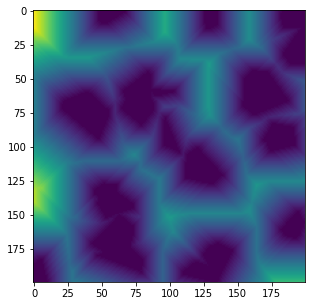

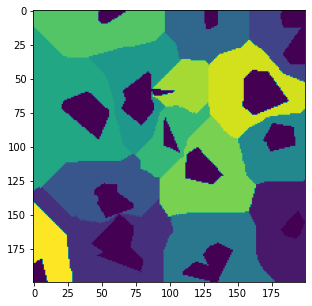

In [3]:
img_done, obs_img_done = brushfire(img, obs_img, all_obs_pts)

plt.figure()
plt.imshow(img_done)

plt.figure()
plt.imshow(obs_img_done)
    

In [4]:
class Node():
    def __init__(self, xy, hfunc):
        self.neighbors = {}
        self.g = np.Inf
        self.xy = np.array(xy)
        self.hfunc = hfunc

    def __lt__(self, other):
        lt = False
        f1 = self.g+self.hfunc(self.xy)
        f2 = other.g+self.hfunc(self.xy)
        if np.abs(f1-f2) < 0.001:
            #print("almost equal")
            lt = self.g > other.g
        else:
            lt = f1 < f2
            
        #lt = f1 < f2
        return lt

    def __eq__(self, other):
        return all(self.xy == other.xy)
    
    def __call__(self):
        return self.hfunc(np.array([self.x, self.y]))
        try:
            return self.f
        except:
            self.f = self.g+self.hfunc(np.array([self.x, self.y]))
            return self.f


class Graph():
    def __init__(self, dist_func):
        self.nodes = {}
        self.dist_func = dist_func
        
    def __iadd__(self, t):
        n1 = t[0]
        n2 = t[1]
        weight = t[2]
        self.connect(n1, n2, weight)
        return self
        
    def connect(self, n1, n2, weight):
        try:
            self.nodes[n1].neighbors[n2] = weight
        except KeyError:
            self.nodes[n1] = Node(n1, self.hfunc)
            self.nodes[n1].neighbors[n2] = weight
        try:
            self.nodes[n2].neighbors[n1] = weight
        except KeyError:
            self.nodes[n2] = Node(n2,self.hfunc)
            self.nodes[n2].neighbors[n1] = weight

    def draw(self, ax):
        for pt in self.nodes:
            node = self.nodes[pt]
            for neighbor in node.neighbors:
                ax.plot([pt[0],neighbor[0]],[pt[1], neighbor[1]],'k')
                
    def hfunc(self, node):
        return self.dist_func(node, self.goal)
        

def h_l2_dist(node, goal):
    return np.linalg.norm(node-goal)

import heapq

def a_star(graph, start, goal, max_iter = np.Inf):
    start_node = graph.nodes[start[0], start[1]]
    start_node.g = 0

    goal_node = graph.nodes[goal[0], goal[1]]
    graph.goal = goal

    start_node.goal = goal
    Q = [start_node]
    heapq.heapify(Q)
    searched = []
    curr_node = start_node
    count = 0
    while len(Q) > 0 and curr_node != goal_node and count < max_iter:
        curr_node = heapq.heappop(Q)
        count += 1

        searched.append(curr_node.xy)
        for neighbor in curr_node.neighbors:
            weight = curr_node.neighbors[neighbor]
            try:
                other_node = graph.nodes[neighbor]
                if curr_node.g + weight < other_node.g:
                    other_node.g = curr_node.g + weight
                    other_node.prev = curr_node
                    if other_node not in Q:
                        other_node.goal = goal
                        heapq.heappush(Q, other_node)
            except:
                pass
    if len(Q) == 0:
        print("No solution found")
        return graph, np.array([[start_node.x, start_node.y]]), np.array(searched), 0
    path = [curr_node.xy]
    path_cum_length = [0]
    path_length = 0
    while curr_node != start_node:
        path.insert(0, curr_node.prev.xy)
        path_length += np.linalg.norm(curr_node.xy-curr_node.prev.xy)
        path_cum_length.append(path_length)
        curr_node = curr_node.prev

    return graph, np.array(path), np.array(searched), np.array(path_cum_length)

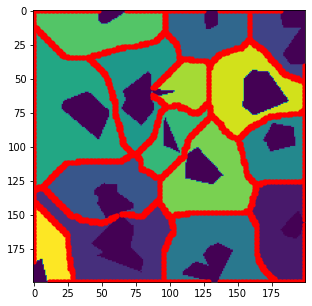

In [9]:
def get_neighbor_vals(img, pt):
    vals = []
    for pair in pairs:
        a = pt[0] + pair[0]
        b = pt[1] + pair[1]
        if a >= 0 and a < img.shape[1] and b >= 0 and b < img.shape[0]:
            vals.append(img[b,a])
    return vals

def is_boundary_pt(img, pt):
    col, row = pt
    neighbor_vals = get_neighbor_vals(img,pt)
    for val in neighbor_vals:
        if img[row,col] >=0:
            if row == 0 or col == 0 or row == img.shape[0]-1 or col == img.shape[1]-1:
                return True
            
            if img[row, col] != val and val >= 0:
                return True
    return False


                        
boundary_pts = []
for row in range(obs_img_done.shape[0]):
    for col in range(obs_img_done.shape[1]):
        if is_boundary_pt(obs_img_done, [col,row]):
            boundary_pts.append([col,row])
boundary_pts = np.array(boundary_pts)
fig, ax = plt.subplots()
ax.imshow(obs_img_done)
ax.plot(boundary_pts[:,0],boundary_pts[:,1],'r.')
                

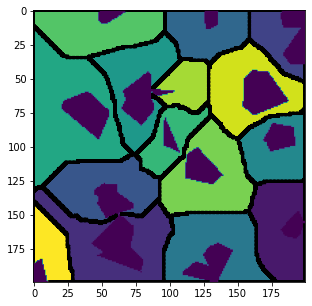

In [10]:
def get_neighbors(img, pt):
    col, row = pt
    neighbors = []
    for pair in pairs:
        a = col + pair[0]
        b = row + pair[1]
        if a >= 0 and a < img.shape[1] and b >= 0 and b < img.shape[0]:
            neighbors.append((a,b))
    return neighbors

def create_graph(img):
    graph = Graph(h_l2_dist)
    for row in range(img.shape[0]):
        for col in range(img.shape[1]):
            for neighbor in get_neighbors(img, (col,row)):
                if is_boundary_pt(img, (col,row)) and is_boundary_pt(img, neighbor):
                        graph += ((col,row), neighbor, np.linalg.norm(np.array((col,row))-np.array(neighbor)))
    return graph

graph = create_graph(obs_img_done)

fig, ax = plt.subplots()
ax.imshow(obs_img_done)
graph.draw(ax)



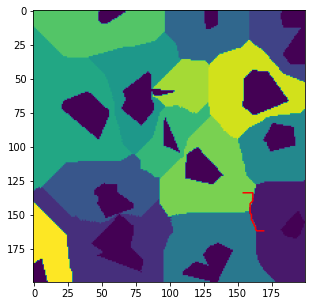

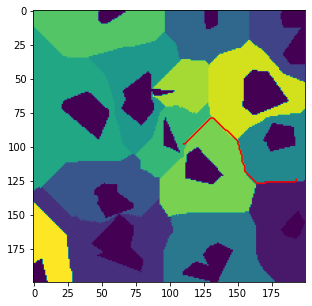

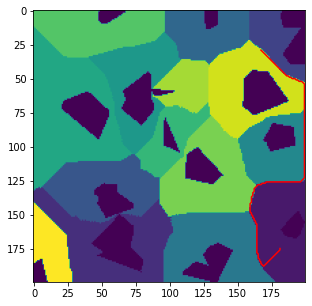

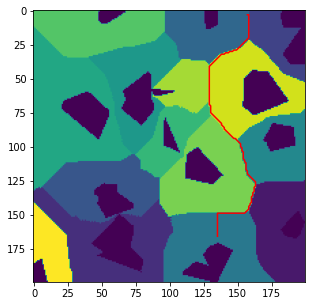

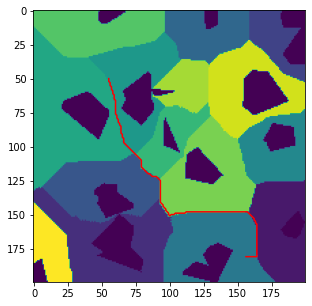

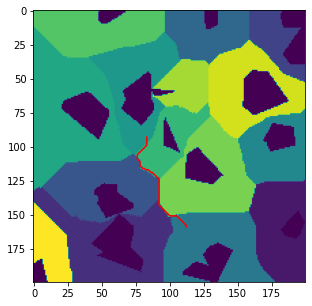

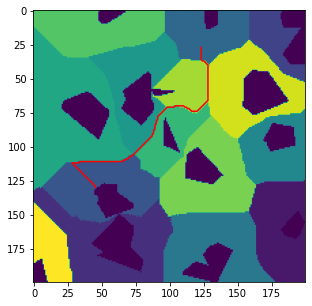

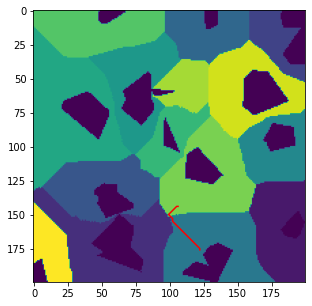

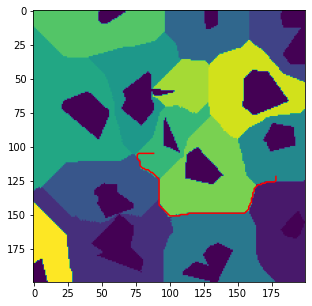

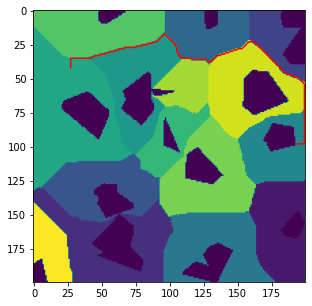

In [12]:
import copy

def find_path(img, graph, start_pt, goal_pt):
    graph = copy.deepcopy(graph)
    curr_pt = tuple(start_pt)
    start_path = []
    count = 0
    start_path.append(curr_pt)
    skip_graph = False

    while not curr_pt in graph.nodes and count < 1000:
        count +=1
#         print(curr_pt, img[curr_pt[1],curr_pt[0]])
        min_dist = 2
        for nx,ny in get_neighbors(img, curr_pt):
#             print((nx,ny), img[ny,nx])
            dist = np.sqrt((nx-curr_pt[0])**2+(ny-curr_pt[1])**2)
            if img[ny,nx] > img[curr_pt[1], curr_pt[0]] and dist < min_dist:
                min_pt = (nx,ny)
                min_dist = dist
        curr_pt = min_pt
        start_path.append(curr_pt)
    if count >= 1000:
        skip_graph = True
        print("problem")

    
    curr_pt = tuple(goal_pt)
    goal_path = []
    count = 0
    goal_path.insert(0, curr_pt)
    while not curr_pt in graph.nodes and count < 1000:
        goal_path.insert(0, curr_pt)
        count +=1
#         print(curr_pt, img[curr_pt[1],curr_pt[0]])
        min_dist = 2
        for nx,ny in get_neighbors(img, curr_pt):
#             print((nx,ny), img[ny,nx])
            dist = np.sqrt((nx-curr_pt[0])**2+(ny-curr_pt[1])**2)
            if img[ny,nx] > img[curr_pt[1], curr_pt[0]] and dist < min_dist:
                min_pt = (nx,ny)
                min_dist = dist
        curr_pt = min_pt
        goal_path.insert(0, curr_pt)
    if count >= 1000:
        skip_graph = True
        print("problem")
    if not skip_graph:
        new_graph, roadmap_path, searched, path_cum_length = a_star(graph, start_path[-1], goal_path[0])
        return np.concatenate([start_path ,roadmap_path , goal_path])
    else:
        return np.concatenate([start_path , goal_path])

for i in range(10):
    while True:
        start_pt = np.random.randint(0,img_done.shape[0],2)
        if img_done[start_pt[1], start_pt[0]] > 0:
            break
#     print(start_pt)
    while True:
        goal_pt = np.random.randint(0,img_done.shape[0], 2)
        if img_done[goal_pt[1], goal_pt[0]] > 0:
            break
#     print(goal_pt)
        
    path = find_path(img_done, graph, start_pt, goal_pt)
    fig, ax = plt.subplots()
    ax.imshow(obs_img_done)
    ax.plot(path[:,0],path[:,1],'r')


                